# 3. Quantify extracellular RNA

After defining extracellular transcripts (previous notebooks), we will now focus on characterizing and quantifying the presence of exRNA for the different genes profiled in the dataset employing different strategies and tests

## Import packages

In [1]:
import spatialdata as sd

import troutpy

/home/sergio/.local/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/sergio/.local/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/home/sergio/.local/lib/python3.10/site-packages/anndata/utils.py:429: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


## Read the SpatialData object

We read the processed Spatialdata object, which was previously stored as .zarr

In [2]:
xenium_path_cropped = "/media/sergio/Meninges/troutpy/xenium_msbrain/mousebrain_prime_crop_communication.zarr"
sdata = sd.read_zarr(xenium_path_cropped)

## Testing for expression over noise levels

We implemented `troutpy.tl.quantify_overexpression` to identify **overexpressed genes relative to a noise threshold**.

Essentially, it computes a threshold based on the counts of specified control features and compares gene counts against this threshold to determine overexpression. The function calculates log-fold changes for each gene, annotates metadata with these results. It returns updated spatial data along with per-gene scores and the calculated threshold

In [3]:
control_codewords = ["negative_control_probe", "unassigned_codeword", "deprecated_codeword", "genomic_control_probe", "negative_control_codeword"]

troutpy.tl.quantify_overexpression(
    sdata,
    layer="transcripts",
    codeword_key="codeword_category",
    control_codewords=control_codewords,
    gene_key="feature_name",
    percentile_threshold=99.99,
)

## Testing for proportion of extracellular transcripts

The `troutpy.tl.extracellular_enrichment` function computes the proportions of extracellular and intracellular transcripts for each gene. 

Essentially, the function calculates: (1) the proportion of transcripts of each gene present extracellularly and (2) the log fold change of extracellular to intracellular proportions.  These results into the `sdata` object under the `xrna_metadata` layer.

In [4]:
troutpy.tl.extracellular_enrichment(sdata)

## Testing for Spatial Variability

The `troutpy.tl.spatial_variability` function quantifies the spatial variability of extracellular RNA using Moran's I, a metric for spatial autocorrelation.

In [3]:
del sdata["segmentation_free_table"]

In [4]:
# troutpy.tl.
troutpy.tl.spatial_variability(sdata, gene_key="feature_name", n_neighbors=10, square_size=20)

Computing segmentation-free aggregation of extracellular transcripts...


## Testing for local density

The `spatial_colocalization` function evaluates the spatial colocalization of extracellular RNA transcripts in spatial transcriptomics data by identifying regions where transcripts from the same or different genes are found in close proximity. The function calculates the proportion of colocalized transcripts for each gene, using a user-defined threshold to define colocalization, and integrates these results into the metadata of the dataset for downstream analysis.

The function calculates the proportion of colocalized transcripts for each gene based on a user-defined threshold, leveraging kernel density estimation to compute spatial gene expression densities. Results are integrated into the `sdata` object under the `xrna_metadata` layer.

In [6]:
troutpy.tl.spatial_colocalization(
    sdata, coord_keys=["x", "y"], gene_key="feature_name", resolution=1000, square_size=5, threshold_colocalized=1, copy=False
)

Extracting gene counts: 100%|██████████| 13031/13031 [00:07<00:00, 1821.18it/s]


# Intracellular_extracellular_correlation

In [95]:
# this is temporary, since currently extracellular def is wrong on test data
transcripts = sdata["transcripts"].compute()  # type: ignore
transcripts["extracellular"] = ~transcripts["extracellular"]
sdata["transcripts"] = sd.models.PointsModel.parse(transcripts)

In [8]:
troutpy.pp.aggregate_extracellular_transcripts(sdata, square_size=8)
troutpy.tl.in_out_correlation(sdata, n_neighbors=20)

## Save SpatialData as zarr

The resulting dataset is finally stored in a new zarr object

In [10]:
xenium_path_cropped = "/media/sergio/Discovair_final/mousebrain_prime_crop_communication.zarr"
sdata.write(xenium_path_cropped, overwrite=True)

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside /media/sergio/Discovair_final/mousebrain_prime_crop_communication.zarr). Please see the 
         documentation of `is_self_contained()` to understand the implications of working with SpatialData objects 
         that are not self-contained.                                                                              
INFO     The Zarr backing store has been changed from                                                              
         /media/sergio/Discovair_final/mousebrain_prime_crop_communication_2.zarr the new file path:               
         /media/sergio/Discovair_final/mousebrain_prime_crop_communication.zarr                                    


### ---TO DO--- Create visualization for the output of different tests

In [ ]:
xenium_path_cropped = "/media/sergio/Discovair_final/mousebrain_prime_crop_quantified.zarr"
sdata = sd.read_zarr(xenium_path_cropped)

In [ ]:
exrna_metrics = sdata["xrna_metadata"].var
# This ones are the most interesting ones, but others can be used
exrna_metrics_filt = exrna_metrics.loc[:, ["logfoldratio_over_noise", "logfoldratio_extracellular", "moran_I", "proportion_of_colocalized"]]

#### PLOTTING FUNCTION 1 (troutpy.pl)- lfr_over_noise grouped by gene type
- **Aim**: Represent the logfoldratio over noise for different genes
- **Input**: sdata["xrna_metadata"].var
- **Suggested Type of plot**: Either barplot, violin or stripplot, representing logfoldration over noise (`sdata["xrna_metadata"]['logfoldratio_over_noise']`),  grouping genes in based on wether they are control probes or not (in sdata["xrna_metadata"].var['control_probe'] column)
-  **Returns**: None (besides the plot) 

False


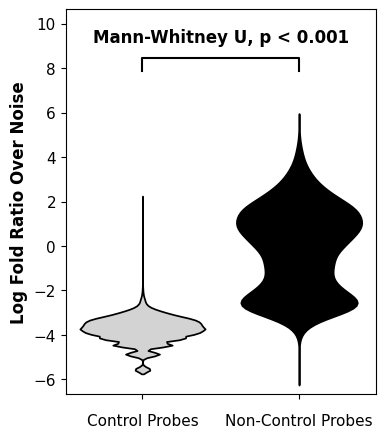

In [4]:
troutpy.pl.logfoldratio_over_noise(sdata, test_method="auto")

In [26]:
import pandas as pd

pd.crosstab(sdata["xrna_metadata"].var["p_value_Poisson"] < 0.00005, sdata["xrna_metadata"].var["control_probe"])

control_probe,False,True
p_value_Poisson,,
False,443,7805
True,4562,224


In [ ]:
troutpy.pl.metric_scatter(sdata, x_metric="proportion_of_colocalized", y_metric="extracellular_proportion", label_top_n_x=3, label_top_n_y=3)

ValueError: Invalid metric. Choose from: moran_I, logfoldratio_extracellular, proportion_of_colocalized, extracellular_proportion, intracellular_proportion

#### PLOTTING FUNCTION 2 (troutpy.pl) Sorted scatterplot/barplot 
- **Aim**: Represent, for a given metric, the genes sorted by them. (the logfoldratio extracellular or extracellular_proportion). Maybe highlighting top-bottom genes with highest-lower scores
- **Input**: sdata -- from which all info needed will be under `sdata["xrna_metadata"].var`, the name column in `sdata["xrna_metadata"].var` (str) (e.g. 'moran_i','extracellular_proportion')
- **Suggested Type of plot**: Either sorted scatter plot, stripplot,barplot or similar, representing extracellular proportion over genes. Maybe color based on  sdata["xrna_metadata"].var['control probe']
- **Return**: None

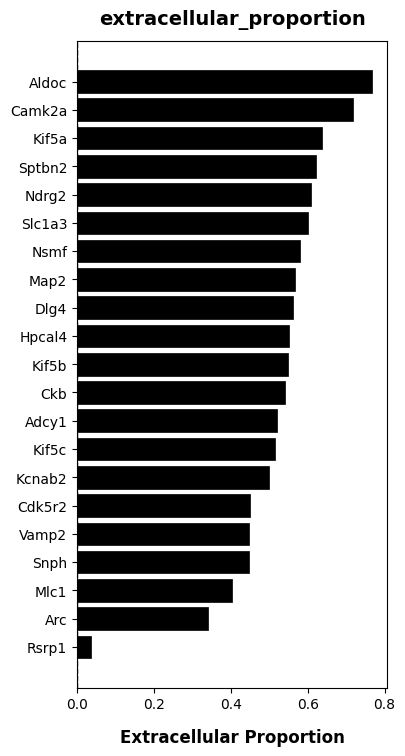

In [113]:
troutpy.pl.top_bottom_probes_of_metric(sdata, metric="extracellular_proportion", top_n=20, bottom_n=1, title="extracellular_proportion")

#### PLOTTING FUNCTION 3 (troutpy.pl)- Scatterplot
- **Aim**: For each gene, represent two of the metrics side by side, in the form of a scatter plot
- **Input**: sdata -- from which all info needed will be under sdata["xrna_metadata"].var, x and y axes
- **Suggested Type of plot**: Scatterplot, maybe colored by control probe column as well
(sdata["xrna_metadata"].var['control probe'])
- **Return**: None

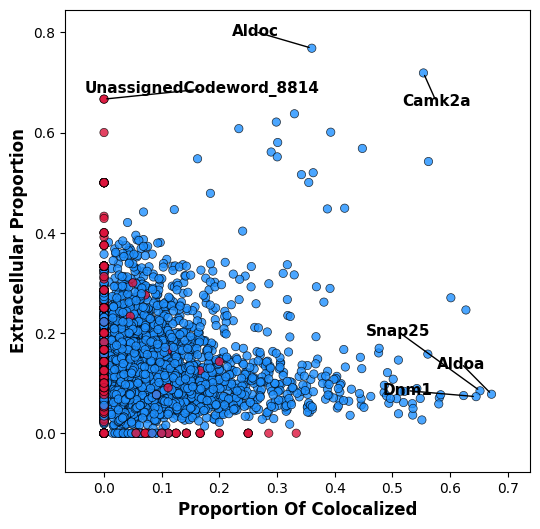

In [ ]:
troutpy.pl.metric_scatter(sdata, x_metric="proportion_of_colocalized", y_metric="extracellular_proportion", label_top_n_x=3, label_top_n_y=3)

#### PLOTTING FUNCTION 4 (troutpy.pl)- Summary visualization
- **Aim**: Represent in a tabular plot (heatmap, dotplot) the overall score for individual genes on different metrics.
- **Input**: sdata -- from which all info needed will be under `sdata["xrna_metadata"].var`, list of columns in `sdata["xrna_metadata"].var`, maybe list of genes to be visualized? if all are too many.
- **Suggested Type of plot**: Heatmap, dotplot or similar. Take sc.pl.dotplot/ sc.tl.matrixplot as reference?
- **Return**: None

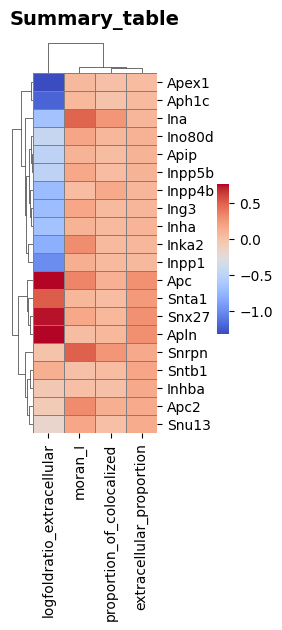

In [ ]:
troutpy.pl.gene_metric_heatmap(
    sdata,
    probes_to_plot=sdata["xrna_metadata"].var.index[:20],
    cluster_axis="both",
    metrics=["moran_I", "proportion_of_colocalized", "extracellular_proportion", "logfoldratio_extracellular"],
    title="Summary_table",
)

# Filter sdata

In [28]:
troutpy.pp.filter_xrna(sdata, min_logfoldratio_over_noise=3)

# Part 2: Test for diffusion 

We next aim to test if patterns observed outside cells are a consequence or diffussion or not

In [29]:
troutpy.tl.assess_diffussion(sdata, gene_key="feature_name", distance_key="distance")

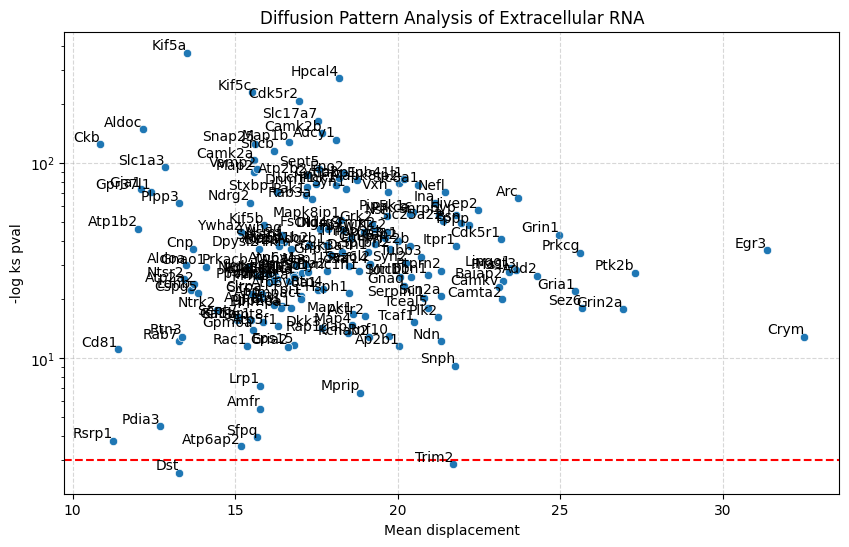

In [30]:
troutpy.pl.diffusion_results(sdata, y_col="-log_ks_pval", y_logscale=True)

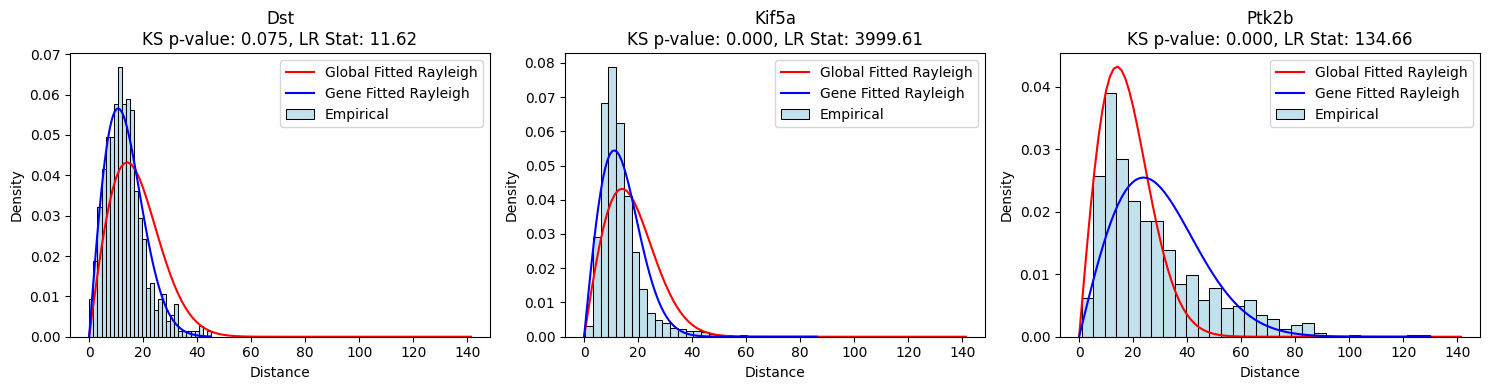

In [ ]:
troutpy.tl.gene_distribution_from_source(sdata, ["Dst", "Kif5a", "Ptk2b"])

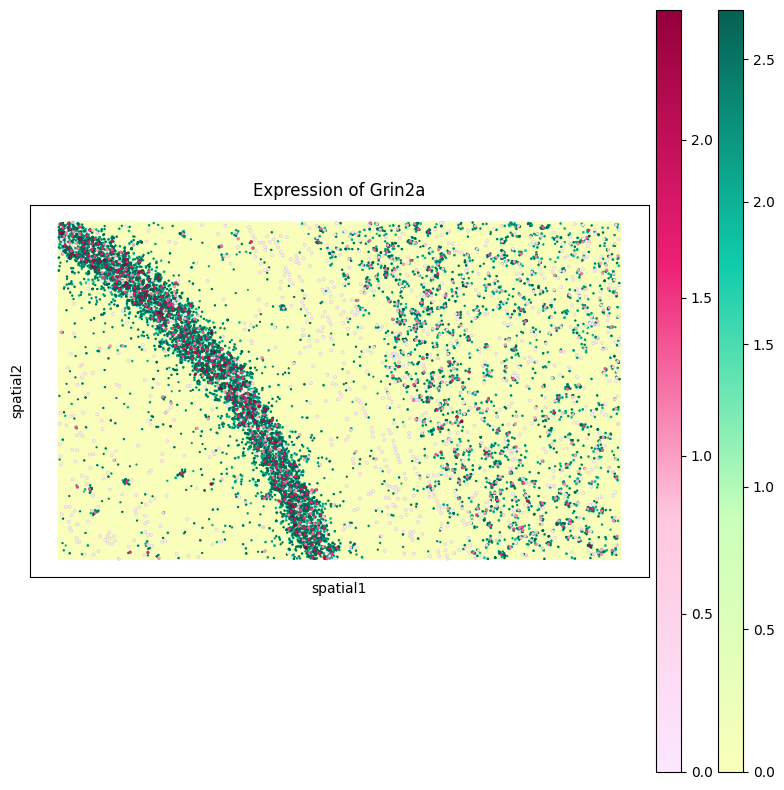

In [49]:
troutpy.pl.spatial_inout_expression(sdata, "Grin2a", spot_size_cells=6, spot_size_extra=4)

In [ ]:
# Other type of spatial plot- very relevant
troutpy.pl.spatial_transcripts(
    sdata,
    gene_key="gene",
    gene_list=["Arc"],
    colormap="30colors",
    color_key="transcript_type",
    scatter_size=6,
    boundary_linewidth=0.5,
    alpha=0.9,
    use_roi=True,
    roi=(4000, 4500, 4500, 4800),
    shapes_key="nucleus_boundaries",
)

# Cluster distribution from source
Next, we cluster distribution from source to identify genes presenting the same patterns

In [46]:
troutpy.tl.cluster_distribution_from_source(sdata, n_clusters=4)

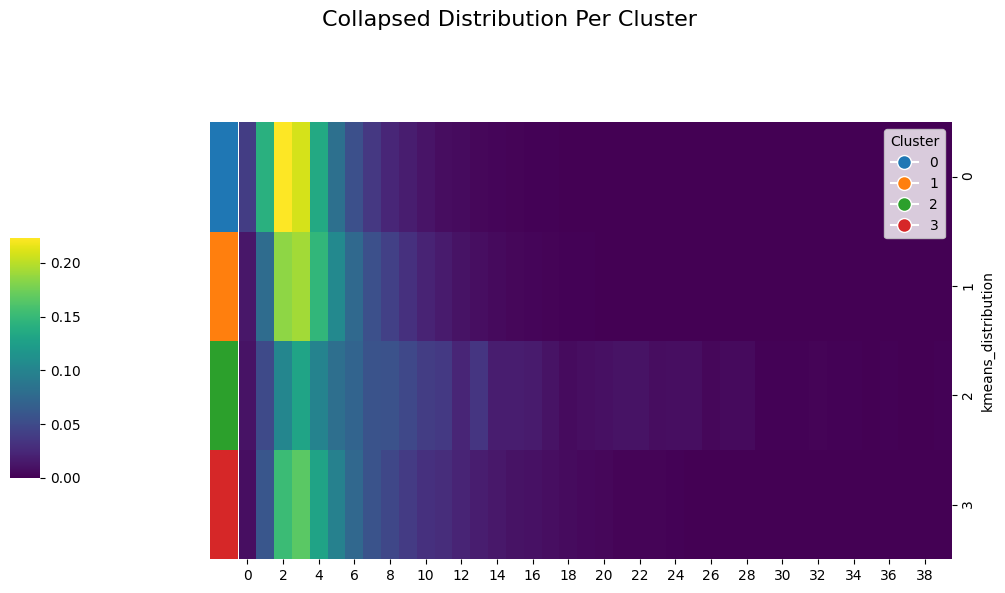

In [47]:
troutpy.pl.global_distribution_from_source(
    sdata, cluster_key="kmeans_distribution", feature_key="feature_name", distance_key="distance", n_bins=40, how="collapsed"
)

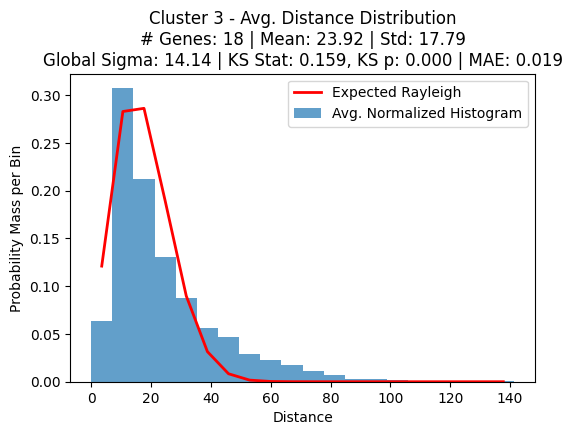

In [14]:
troutpy.pl.distributions_by_cluster(sdata, groups=[3])

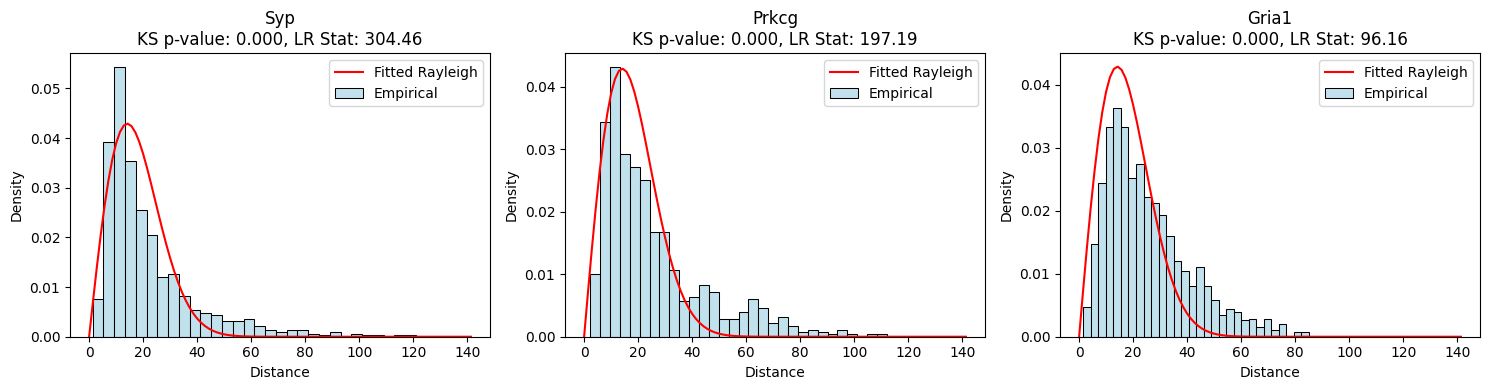

In [15]:
cool_pattern_df = sdata["xrna_metadata"].var[sdata["xrna_metadata"].var["kmeans_distribution"] == 3.0]
selected_genes = cool_pattern_df.sort_values(by="count", ascending=False).index
troutpy.pl.gene_distribution_from_source(sdata, selected_genes[0:3])

# Intra vs extracellular distribution

In [100]:
troutpy.tl.compare_intra_extra_distribution(sdata, copy=False, n_bins=20)

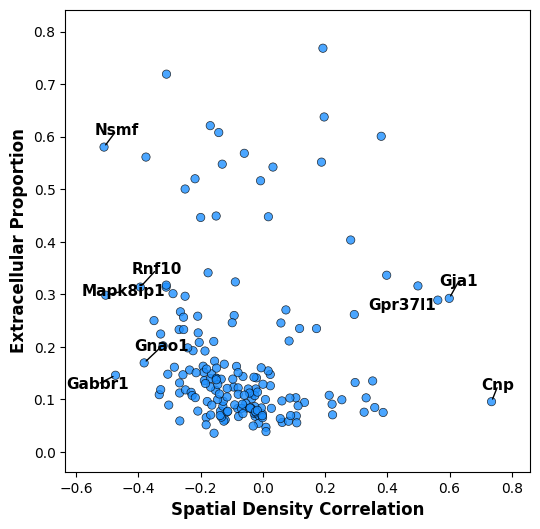

In [ ]:
troutpy.tl.metric_scatter(
    sdata, x_metric="spatial_density_correlation", y_metric="extracellular_proportion", label_top_n_x=3, label_bottom_n_y=0, label_bottom_n_x=5
)

In [102]:
bottom_genes = sdata["xrna_metadata"].var.sort_values(by="spatial_density_correlation")["spatial_density_correlation"].keys()[0:3]
top_genes = sdata["xrna_metadata"].var.sort_values(by="spatial_density_correlation", ascending=False)["spatial_density_correlation"].keys()[0:3]

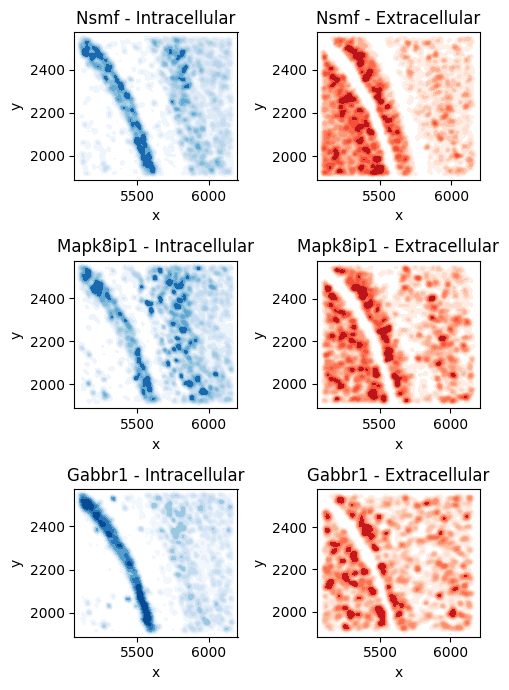

In [104]:
troutpy.pl.intra_extra_density(
    sdata,
    bottom_genes,
    layer="transcripts",
    gene_key="feature_name",
    coord_keys=["x", "y"],
    intra_kde_kwargs={"fill": True, "cmap": "Blues", "thresh": 0.05, "bw_adjust": 0.2},
    extra_kde_kwargs={"fill": True, "cmap": "Reds", "thresh": 0.05, "bw_adjust": 0.2},
    figsize=(5, 7),
)

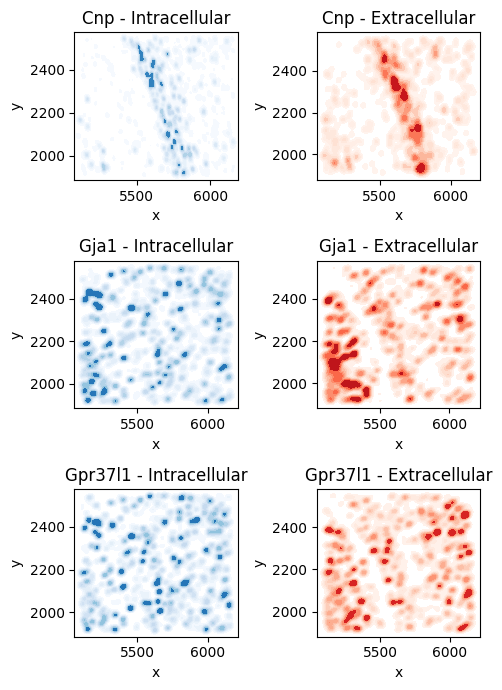

In [105]:
troutpy.pl.intra_extra_density(
    sdata,
    top_genes,
    layer="transcripts",
    gene_key="feature_name",
    coord_keys=["x", "y"],
    intra_kde_kwargs={"fill": True, "cmap": "Blues", "thresh": 0.05, "bw_adjust": 0.2},
    extra_kde_kwargs={"fill": True, "cmap": "Reds", "thresh": 0.05, "bw_adjust": 0.2},
    figsize=(5, 7),
)

In [111]:
sdata["xrna_metadata"].var.sort_values(by="spatial_density_correlation").head(5).index

Index(['Nsmf', 'Mapk8ip1', 'Gabbr1', 'Rnf10', 'Gnao1'], dtype='object')

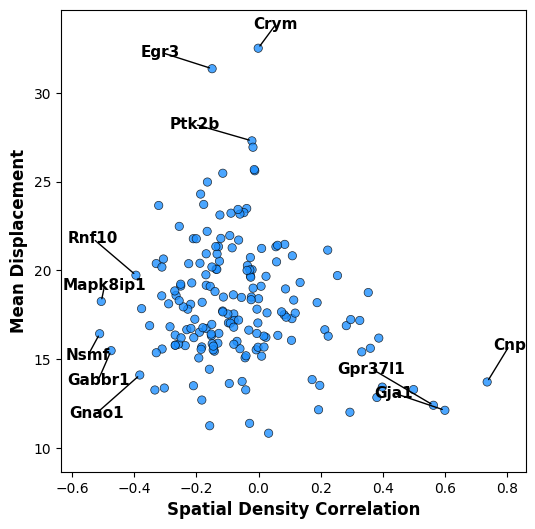

In [ ]:
troutpy.pl.metric_scatter(
    sdata, x_metric="spatial_density_correlation", y_metric="mean_displacement", label_top_n_x=3, label_top_n_y=3, label_bottom_n_x=5
)

# Cell_projection_score

In [ ]:
import numpy as np


def compute_projection_score(sdata):
    """
    Compute a segmentation score for each cell based on the expression of genes weighted by their intracellular proportion (1 - extracellular proportion).

    Parameters
    ----------
    sdata : dict
        A spatialdata object with keys 'table' and 'xrna_metadata'.
        - sdata['table'] is an AnnData object containing expression data in layers['raw']
          and cell metadata in .obs.
        - sdata['xrna_metadata'].var is a DataFrame with gene names as the index and
          an 'extracellular proportion' column.

    Returns
    -------
    sdata : dict
        The same sdata object with a new column 'segmentation_score' in sdata['table'].obs.
    """
    # Retrieve the AnnData object with cells in .obs and genes in .var
    adata = sdata["table"]

    # Retrieve raw expression data; assume shape (n_cells, n_genes)
    raw_expr = adata.layers["raw"]

    # If raw_expr is a sparse matrix, convert to a dense array
    if hasattr(raw_expr, "toarray"):
        raw_expr = raw_expr.toarray()

    # Get gene names from the AnnData object
    genes = adata.var_names

    # Retrieve gene metadata containing the extracellular proportions
    gene_meta = sdata["xrna_metadata"].var

    # Identify the genes common to both the expression data and the metadata
    common_genes = gene_meta.index.intersection(genes)
    if len(common_genes) == 0:
        raise ValueError("No common genes found between adata and gene metadata.")

    # Subset the expression matrix to only those common genes
    # Here we assume adata.var_names preserves order; get indices corresponding to common genes.
    common_idx = [i for i, gene in enumerate(genes) if gene in common_genes]
    raw_expr = raw_expr[:, common_idx]

    # Reorder gene_meta so that it matches the ordering in the expression data.
    # This assumes that the order of genes in adata.var_names is the desired order.
    ordered_genes = [gene for gene in genes if gene in common_genes]
    gene_weights = gene_meta.loc[ordered_genes, "extracellular_proportion"]

    # Convert extracellular proportion to intracellular weight (1 - extracellular proportion)
    intracellular_weights = 1 - gene_weights.values  # numpy array

    # Compute the numerator and denominator for the weighted average per cell.
    # Numerator: dot product of cell expression with intracellular weights.
    # Denominator: total expression (for the common genes) per cell.
    numerator = raw_expr.dot(intracellular_weights)
    denominator = raw_expr.sum(axis=1)

    # Avoid division by zero (if a cell has zero expression for these genes)
    score = np.divide(numerator, denominator, out=np.full_like(numerator, np.nan), where=denominator != 0)

    # Store the score in the AnnData object under obs
    adata.obs["projection_score"] = score


#   return sdata

# Example usage:
# sdata = compute_segmentation_score(sdata)

In [158]:
sdata["xrna_metadata"].var

,extracellular_proportion,intracellular_proportion,logfoldratio_extracellular,moran_I,moran_pval_norm,moran_var_norm,moran_pval_norm_fdr_bh,proportion_of_colocalized,count,logfoldratio_over_noise,...,ks_stat,ks_pval,ad_stat,lr_stat,mean_displacement,-log_ks_pval,kmeans_distribution,centroid_shift_distance,spatial_density_correlation,spatial_js_divergence
Ina,0.090925,0.909075,-0.663773,0.484794,0.0,0.000106,0.0,0.266400,5609.0,3.072185,...,0.246065,1.111742e-27,32.872169,277.613901,21.139413,62.063869,3,24.187166,0.222317,0.229120
Snrpn,0.162881,0.837119,0.001669,0.501641,0.0,0.000106,0.0,0.265348,6956.0,3.287417,...,0.154974,3.143611e-24,87.421296,288.358414,21.268325,54.116670,3,50.656788,-0.084891,0.220378
Itpr1,0.258344,0.741656,0.584022,0.596320,0.0,0.000106,0.0,0.263566,8659.0,3.506412,...,0.092347,4.724564e-17,183.899169,184.090741,21.783656,37.591171,3,96.100319,-0.209666,0.211115
App,0.059040,0.940960,-1.130068,0.535107,0.0,0.000106,0.0,0.534641,16023.0,4.121838,...,0.104915,1.606786e-09,91.865200,80.100539,15.792096,20.249030,1,53.559410,-0.267170,0.238346
Sorl1,0.077682,0.922318,-0.835653,0.596459,0.0,0.000106,0.0,0.353035,7299.0,3.335550,...,0.153075,4.571735e-12,35.861208,115.366281,20.067471,26.111128,3,78.184616,-0.136484,0.298645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Hivep2,0.232958,0.767042,0.446932,0.612124,0.0,0.000106,0.0,0.322966,10122.0,3.662524,...,0.110647,1.342426e-25,194.367048,298.092706,22.476395,57.270149,3,128.938232,-0.254838,0.242752
Hnrnpa1,0.103397,0.896603,-0.521425,0.482473,0.0,0.000106,0.0,0.317642,7360.0,3.343872,...,0.110563,1.475834e-08,67.697303,85.288195,16.730647,18.031457,1,45.829979,-0.217359,0.250852
Hpcal4,0.551486,0.448514,1.845292,0.545256,0.0,0.000106,0.0,0.300448,12887.0,3.904031,...,0.138119,9.946266e-119,646.050607,1548.470945,18.183786,271.710429,1,78.505859,0.188277,0.191715
Hsph1,0.077395,0.922605,-0.839664,0.526572,0.0,0.000106,0.0,0.317549,6357.0,3.197369,...,0.149737,4.283625e-10,40.257136,103.843944,18.496875,21.571051,1,33.273304,-0.112952,0.280313


In [148]:
compute_projection_score(sdata)

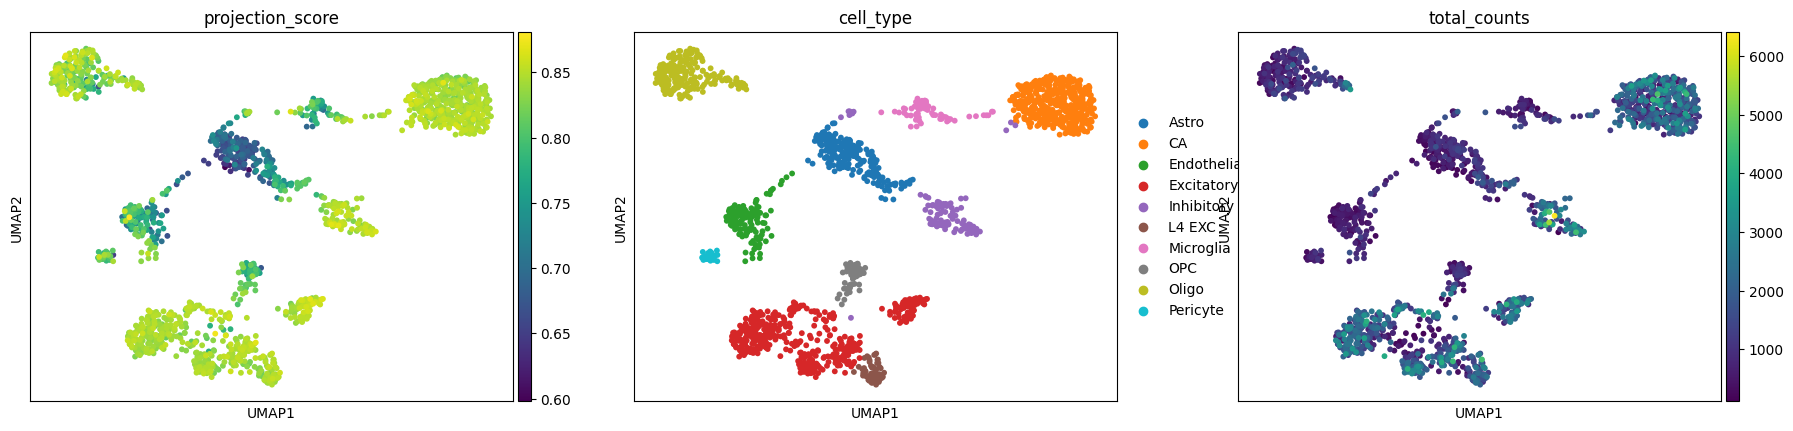

In [200]:
import scanpy as sc

sc.pl.umap(sdata["table"], color=["projection_score", "cell_type", "total_counts"], vmax="p99.997")

In [ ]:
def proportion_of_extracellularly_enriched_genes(sdata, threshold=0.5):
    """For cell, compute the proportion of expressed genes that are extracellularly enriched, i.e. whose extracellular transcript proportion is above a given threshold.

    Parameters
    ----------
    sdata : dict
        A spatialdata object with keys 'table' and 'xrna_metadata'.
        - sdata['table'] is an AnnData object containing expression data in layers['raw']
          and cell metadata in .obs.
        - sdata['xrna_metadata'].var is a DataFrame with gene names as the index and
          an 'extracellular_proportion' column.

    threshold : float, default=0.5
        The minimum extracellular proportion required for a gene to be considered
        "extracellularly enriched".

    Returns
    -------
    sdata : dict
        The same sdata object with a new column 'extracellularly_enriched_proportion'
        in sdata['table'].obs, which contains the computed metric for each cell.
    """
    # Retrieve the AnnData object and raw expression data
    adata = sdata["table"]
    raw_expr = adata.layers["raw"]

    # Convert to dense if necessary
    if hasattr(raw_expr, "toarray"):
        raw_expr = raw_expr.toarray()

    # Get gene names from AnnData and the corresponding gene metadata
    genes = adata.var_names
    gene_meta = sdata["xrna_metadata"].var

    # Find common genes between the expression data and metadata
    common_genes = gene_meta.index.intersection(genes)
    if len(common_genes) == 0:
        raise ValueError("No common genes found between adata and gene metadata.")

    # Get indices of common genes in the expression matrix
    common_idx = [i for i, gene in enumerate(genes) if gene in common_genes]
    raw_expr = raw_expr[:, common_idx]

    # Reorder the gene metadata to match the ordering in the expression data
    ordered_genes = [gene for gene in genes if gene in common_genes]
    extracellular_props = gene_meta.loc[ordered_genes, "extracellular_proportion"].values

    # Create a boolean mask for genes that are extracellularly enriched (above threshold)
    enriched_mask = extracellular_props > threshold

    # Determine which genes are expressed in each cell (expression > 0)
    expressed = raw_expr > 0

    # Count the number of expressed genes per cell
    expressed_count = expressed.sum(axis=1)

    # For each cell, count how many of the expressed genes are extracellularly enriched
    enriched_count = (expressed & enriched_mask).sum(axis=1)

    # Compute the proportion (handling potential division by zero)
    proportion = np.divide(enriched_count, expressed_count, out=np.full_like(enriched_count, np.nan, dtype=float), where=expressed_count != 0)

    # Store the computed metric in the AnnData object under .obs
    adata.obs["extracellularly_enriched_proportion"] = proportion

In [210]:
proportion_of_extracellularly_enriched_genes(sdata, threshold=0.3)

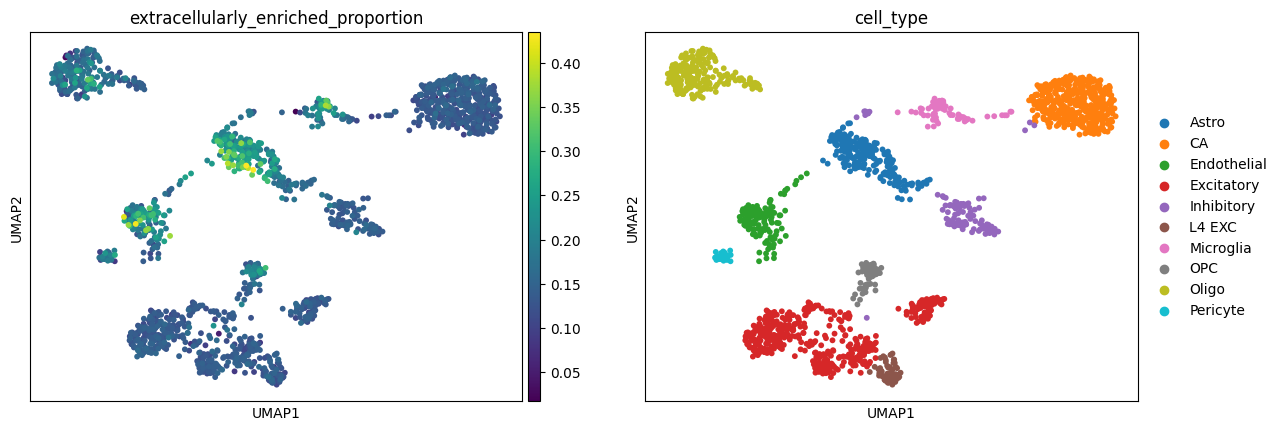

In [211]:
sc.pl.umap(sdata["table"], color=["extracellularly_enriched_proportion", "cell_type"], vmax="p99.9")

In [208]:
extranscripts = sdata["xrna_metadata"].var[sdata["xrna_metadata"].var["extracellular_proportion"] > 0.3].index
selgenes = sdata["table"].var.index[sdata["table"].var.index.isin(extranscripts)]

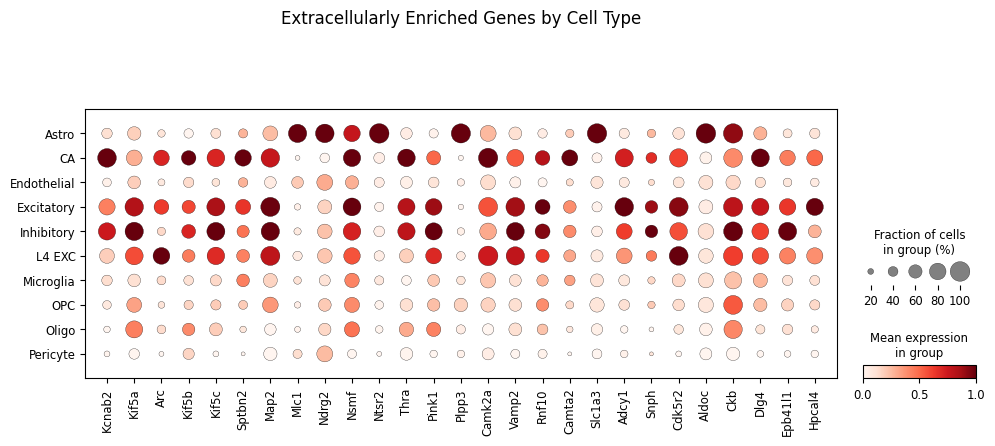

In [209]:
import scanpy as sc

# Ensure your AnnData object (sdata['table']) has a 'cell type' annotation in obs.
sc.pl.dotplot(sdata["table"], extranscripts, groupby="cell_type", standard_scale="var", title="Extracellularly Enriched Genes by Cell Type")